In [1]:
# import all the necessary libraries here
import keras
import pandas as pd
import tensorflow as tf
import numpy as np
from geopy.distance import geodesic
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import cv2
import os

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
def getData(labelpath, picpath):
	labels = pd.read_csv(labelpath, sep=",", header=None)
	labels.columns = ["lat", "lon", "pic"]
	outputs = labels[["lat", "lon"]]
	pic_files = labels["pic"]

	inputs = []

	for file in pic_files:
		# load the image, and resize it to be a fixed
		# 224x224 pixels while ignoring aspect ratio
		image = cv2.imread(picpath+file)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (224, 224)).astype(np.float32)
		# update the input lists
		inputs.append(image)


	# convert the inputs and outputs to NumPy arrays
	inputs = np.array(inputs)
	outputs = np.array(outputs)

	return [inputs, outputs]


# read data for training
[data, labels] = getData("/content/gdrive/My Drive/Colab Notebooks/fdh/label.txt","/content/gdrive/My Drive/Colab Notebooks/fdh/images/")

In [4]:
# normalize data
data = data/255

# normalize labels using min-max
maxlatlon = np.max(labels,axis=0)
minlatlon = np.min(labels,axis=0)
normalized_labels = (labels-minlatlon)/(maxlatlon-minlatlon)

In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, normalized_labels, test_size=0.1, random_state=42)

In [24]:
def custom_loss_function(y_true, y_pred):
   difference = tf.abs(y_true - y_pred)
   return tf.reduce_sum(difference, axis=-1)

# construct modified resnet
baseModel = keras.applications.ResNet101(weights="imagenet", include_top=False,	input_tensor=Input(shape=(224, 224, 3)))

# get the output before the classifier
base_output = baseModel.output

# change classifier to regressor output dimension is 2
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dropout(0.2)(base_output)
base_output = Dense(2, activation='linear', kernel_initializer='normal')(base_output)

model = Model(inputs=baseModel.input, outputs=base_output)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

model.compile(loss="mse", optimizer="adam")

In [25]:
print("[INFO] training head...")
history = model.fit(trainX, trainY, epochs=35, batch_size=128, shuffle=True, validation_data=(testX, testY))

[INFO] training head...
Epoch 1/35
17/17 [==============================] - 12s 719ms/step - loss: 0.2898 - val_loss: 0.0235
Epoch 2/35
17/17 [==============================] - 11s 652ms/step - loss: 0.1927 - val_loss: 0.0248
Epoch 3/35
17/17 [==============================] - 11s 661ms/step - loss: 0.1540 - val_loss: 0.0124
Epoch 4/35
17/17 [==============================] - 11s 667ms/step - loss: 0.1253 - val_loss: 0.0104
Epoch 5/35
17/17 [==============================] - 11s 675ms/step - loss: 0.1045 - val_loss: 0.0095
Epoch 6/35
17/17 [==============================] - 12s 681ms/step - loss: 0.0878 - val_loss: 0.0094
Epoch 7/35
17/17 [==============================] - 12s 688ms/step - loss: 0.0697 - val_loss: 0.0100
Epoch 8/35
17/17 [==============================] - 12s 692ms/step - loss: 0.0607 - val_loss: 0.0082
Epoch 9/35
17/17 [==============================] - 12s 695ms/step - loss: 0.0514 - val_loss: 0.0072
Epoch 10/35
17/17 [==============================] - 12s 698ms/step

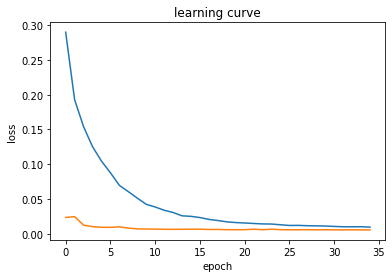

In [26]:
# this block plots the learning curve 
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.title('learning curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

(224, 224, 3)
[[45.43449883 12.33427484]]


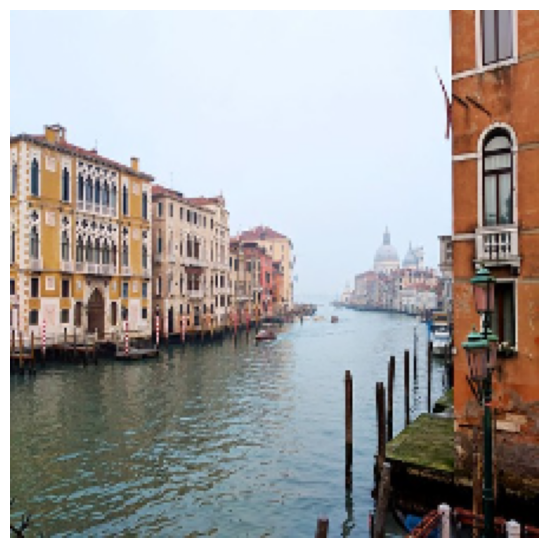

In [27]:
# predict the geolocation of a single input image

#image = cv2.imread("/content/gdrive/My Drive/Colab Notebooks/fdh/images/838.jpg")
image = cv2.imread("/content/gdrive/My Drive/Colab Notebooks/fdh/test8.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
test = cv2.resize(image, (224, 224))
test = trainX[235]

# show image
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), dpi=100, sharex=True, sharey=True)
ax.imshow(test)
ax.axis('off')
print(test.shape)

# predict geolocation
predictY = model.predict((test/255).reshape(1,224,224,3))
#predictY = model.predict(test.reshape(1,224,224,3))
predictY = predictY*(maxlatlon-minlatlon)+minlatlon
print(predictY)

In [28]:
from geopy.distance import geodesic

Yt = testY[235]*(maxlatlon-minlatlon)+minlatlon
print("The correct geolocation is ", str(Yt))
geodesic(Yt, predictY).m

The correct geolocation is  [45.431346 12.332586]


374.497729209967

In [29]:
# compute the average/min/max distance in difference for predict coordinates and the correct coordinates
# run this function on the testing data 
Y_hat = model.predict(testX)
diff = []
for i in range(Y_hat.shape[0]):
  Yp = Y_hat[i]*(maxlatlon-minlatlon)+minlatlon
  Y = testY[i]*(maxlatlon-minlatlon)+minlatlon
  diff.append(geodesic(Yp, Y).m)

diff = np.array(diff)

avg_distance = np.mean(diff)
min_distance = np.min(diff)
max_distance = np.max(diff)
print("Average difference in distance is ", str(avg_distance))
print("Min difference in distance is ", str(min_distance))
print("Max difference in distance is ", str(max_distance))

Average difference in distance is  715.2732210698315
Min difference in distance is  18.055553702512626
Max difference in distance is  2966.3370602652826


In [30]:
# save model
model.save('/content/gdrive/My Drive/Colab Notebooks/fdh/ResNetModel.h5')

In [31]:
len(model.layers)

349

Text(0.5, 1.0, 'Distribution of distance in meters')

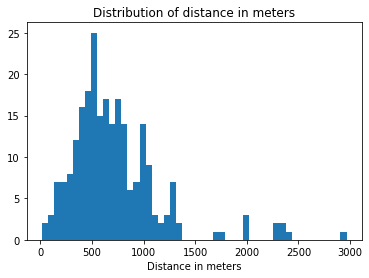

In [32]:
plt.hist(diff,bins=50)
plt.xlabel("Distance in meters")
plt.title("Distribution of distance in meters")